In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_4760\1617189486.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Bootstrapping

Суть бутстрапирования в том, чтобы из имеющейся генеральной совокупности получить множество выборок. Это может быть полезно как:
1. Способ увеличения маленькой выборки
2. Инструмент для оценки распределения метрики
3. Альтернатива изученным ранее статистическим критериям

Будем расчленять знакомый датасет Cookie cats:

In [2]:
data = pd.read_csv("../data/cookie_cats.csv")
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


### Маленькие выборки

После изучения MDE мы пришли к выводу, что выборка была маловата для t-критерия, это уже достаточное обоснование для использования бутстрапа. Но для наглядности возьмём выборку ещё меньше:

<Axes: >

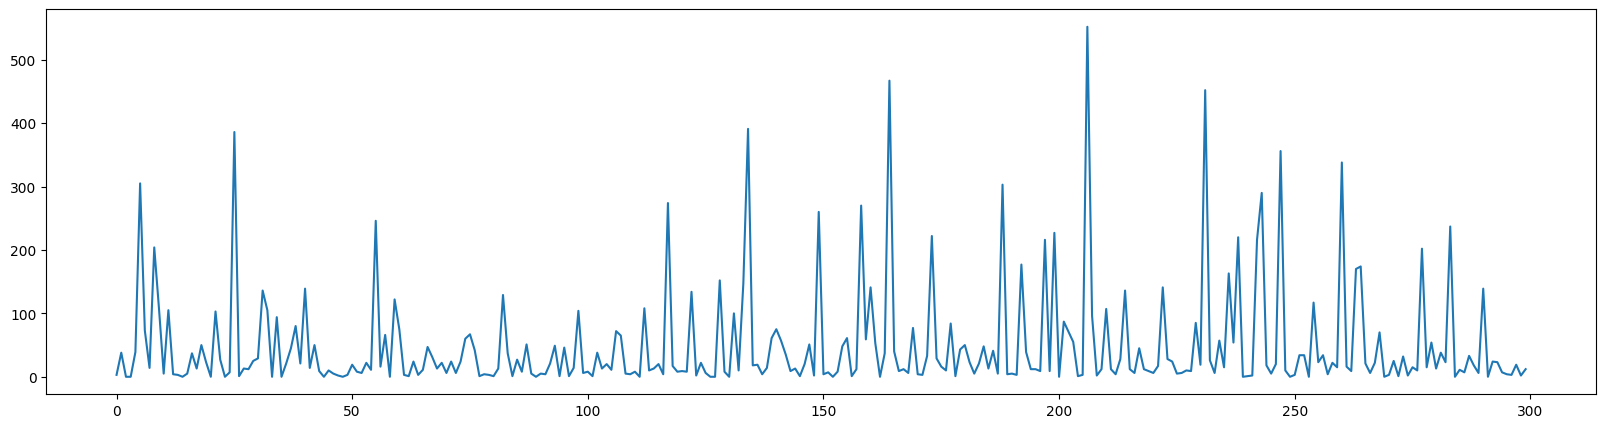

In [11]:
small = data.head(300).reset_index(drop=True)
small.sum_gamerounds.plot(figsize = (20,5))

Будем делать подвыборки такого же маленького размера, но сделаем их много и для каждой посчитаем нашу метрику (среднее):

In [13]:
iterations = 5000
boot_means = []
boot_stds = []
for i in tqdm(range(iterations)):
    # Важно: одно значение исходной выборки может попадать в подвыборку несколько раз,
    # на любой итерации создания подвыборки у всех элементов ГС одинаковая вероятность быть выбранными
    # (сэмплирование с возвращением)
    # Размер каждой подвыборки равен размеру исходной.
    sample = small.sample(frac = 1, replace = True)
    boot_means.append(sample['sum_gamerounds'].mean())
    boot_stds.append(sample['sum_gamerounds'].std())

100%|██████████| 5000/5000 [00:34<00:00, 146.67it/s]


Теперь у нас есть большая выборка метрик.

<Axes: >

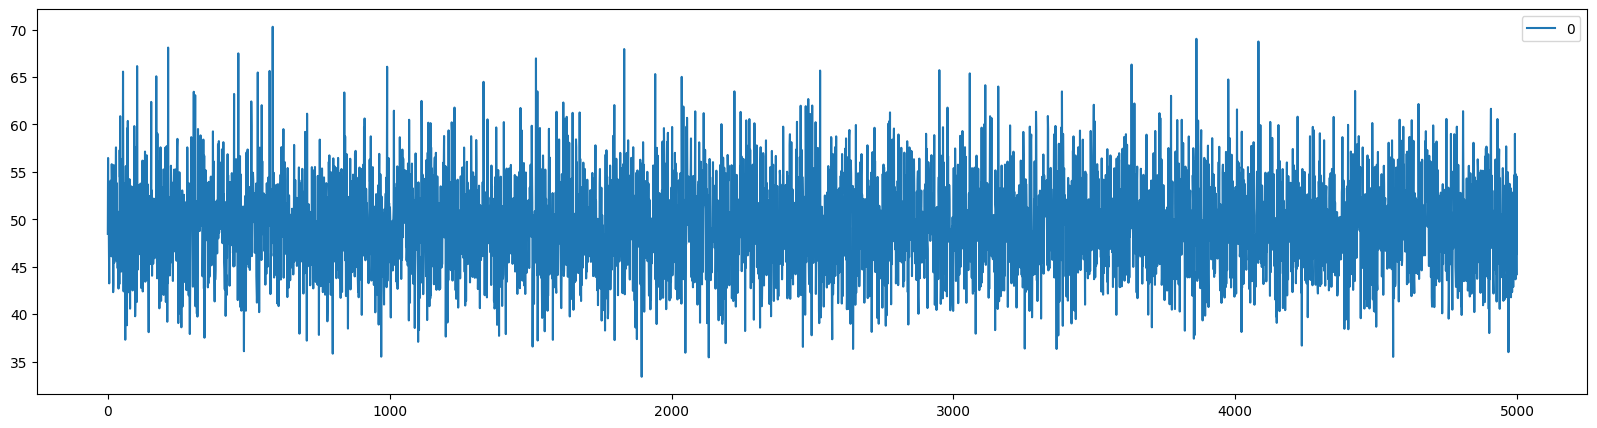

In [15]:
pd.DataFrame(boot_means).plot(figsize = (20,5))

Теперь можем найти среднее значений по всем подвыборкам, это будет наш ответ:

In [17]:
print('Mean:\t', np.mean(boot_means))
print('Std:\t', np.mean(boot_stds))

Mean:	 49.42014933333333
Std:	 83.65773843375958


Вы также столкнётесь или уже столкнулись с бутстрапом для вычисления мат.ожидания и дисперсии на курсе по ML.

### Оценка распределения метрики
Можно вспомнить, что мы уже использовали бутстрап, чтобы показать нормальность распределения средних (условие для t-критерия)

In [18]:
def bootstrap_mean(dataframe, column, iters, name):
    boot_data = []
    for i in tqdm(range(iters)):
        boot_mean = dataframe.sample(frac = 1, replace = True)[column].mean()
        boot_data.append(boot_mean)
    return pd.DataFrame(boot_data, columns=[name])

iterations = 3000
boot_30_ret_mean = bootstrap_mean(data[data.version == 'gate_30'], 'sum_gamerounds', iterations, 'gate_30')
boot_40_ret_mean = bootstrap_mean(data[data.version == 'gate_40'], 'sum_gamerounds', iterations, 'gate_40')
boot_ret_mean = boot_30_ret_mean.merge(boot_40_ret_mean, left_index=True, right_index=True)

100%|██████████| 3000/3000 [00:40<00:00, 74.60it/s] 


Изменение среднего с увеличением количества итераций бутстрапа:

100%|██████████| 300/300 [00:02<00:00, 142.60it/s]


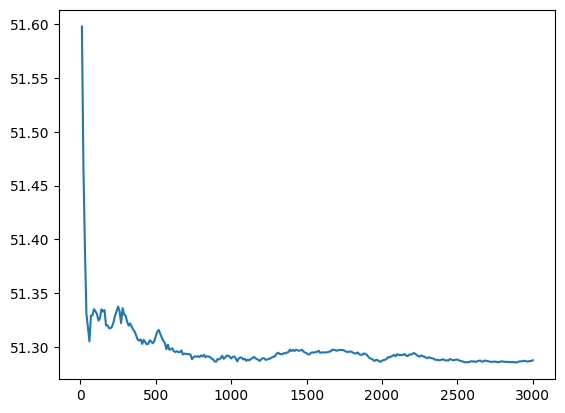

In [42]:
sizes = []
means = []

size = 0
for i in tqdm(range(len(boot_40_ret_mean) // 10)):
    size += 10
    sizes.append(size)
    means.append(boot_40_ret_mean[:size].mean())

plt.plot(sizes, means)
plt.show()

Плотности распределений:

<Axes: ylabel='Frequency'>

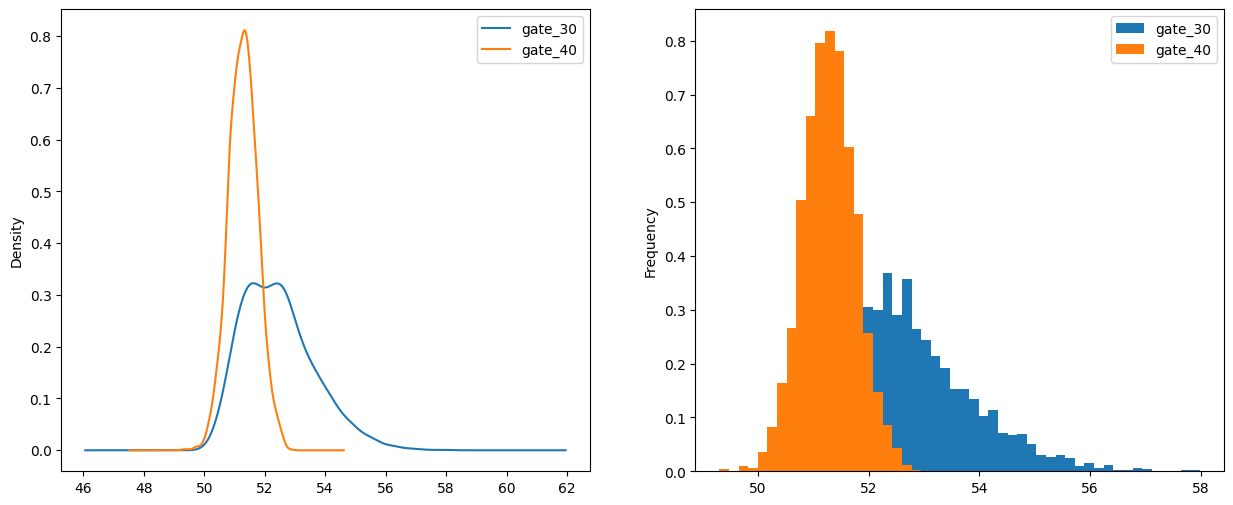

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
boot_ret_mean[["gate_30", "gate_40"]].plot(kind='density', xlabel='means', ax=ax1)
boot_ret_mean[["gate_30", "gate_40"]].plot(kind='hist', bins=50, density=True, ax=ax2)

Почему средние gate_30 значительно смещены вправо? У нас есть выброс. Раньше мы удаляли его, но представим, что выбросов слишком много, чтобы удалять их и не потерять значимые данные:

<Axes: >

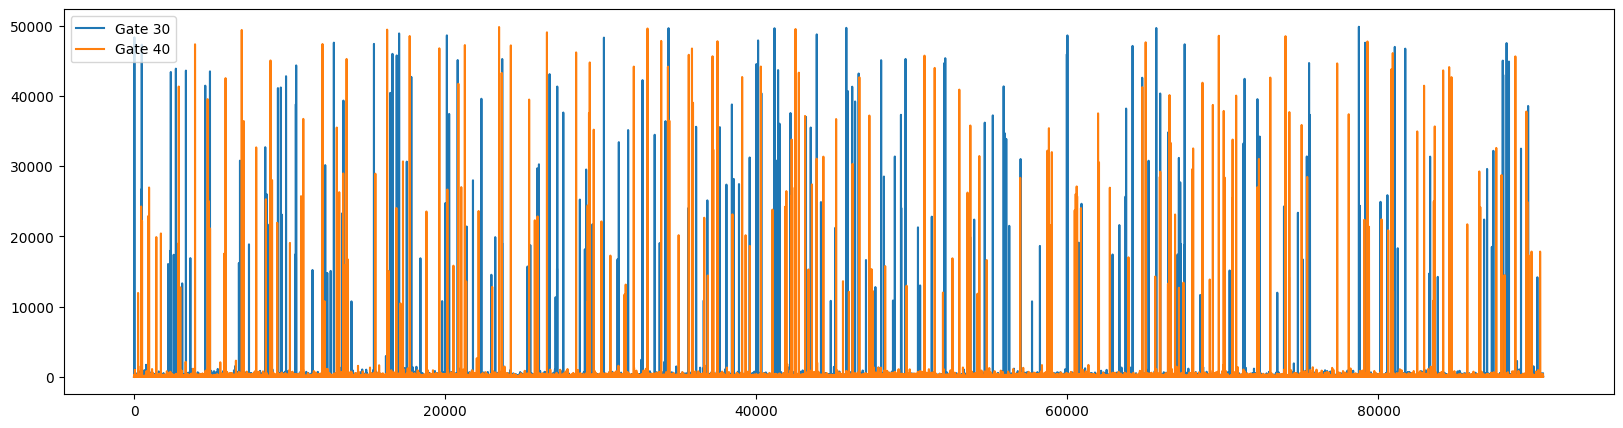

In [28]:
import random

data = pd.read_csv("../data/cookie_cats.csv")
data = data[['version', 'sum_gamerounds']]
for i in range(200):
    data = pd.concat([data,
                       pd.DataFrame({'version': ['gate_30', 'gate_40'],
                                     'sum_gamerounds': [random.randint(10000, 50000), random.randint(10000, 50000)]})])
data = data.sample(frac=1).reset_index(drop=True)
gate_30 = data[data.version == 'gate_30']
gate_40 = data[data.version == 'gate_40']
gate_30.sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
gate_40.sum_gamerounds.plot(legend = True, label = "Gate 40")

В этом случае логичнее использовать медиану, а не среднее

In [34]:
def bootstrap_median(dataframe, column, iters, name):
    boot_data = []
    for i in tqdm(range(iters)):
        boot_median = dataframe.sample(frac = 1, replace = True)[column].median()
        boot_data.append(boot_median)
    return pd.DataFrame(boot_data, columns=[name])

iterations = 2000
boot_30_sum_median = bootstrap_median(gate_30, 'sum_gamerounds', iterations, 'gate_30')
boot_40_sum_median = bootstrap_median(gate_40, 'sum_gamerounds', iterations, 'gate_40')
boot_sum_median = boot_30_sum_median.merge(boot_40_sum_median, left_index=True, right_index=True)

100%|██████████| 10000/10000 [02:44<00:00, 60.69it/s]


Получили набор медиан, среднее значение которого близко к медиане ГС.

In [39]:
print('Gate 30. Original median:', gate_30['sum_gamerounds'].median())
print('Gate 30. Bootstrap median:', boot_sum_median['gate_30'].mean())
print('Gate 40. Original median:', gate_40['sum_gamerounds'].median())
print('Gate 40. Bootstrap median:', boot_sum_median['gate_40'].mean())

Gate 30. Original median: 17.0
Gate 30. Bootstrap median: 16.998
Gate 40. Original median: 16.0
Gate 40. Bootstrap median: 16.1714


Теперь можно посмотреть на распределения медиан.

In [40]:
boot_40_sum_median.value_counts()

gate_40
16.0       8286
17.0       1714
Name: count, dtype: int64

In [41]:
boot_30_sum_median.value_counts()

gate_30
17.0       9968
16.0         26
18.0          6
Name: count, dtype: int64

### Проверка гипотезы

Для проверки гипотезы проводим бутстрап по двум группам и сохраняем разности. Также корректируем смещение.

In [ ]:
data = pd.read_csv("../data/cookie_cats.csv")
gate_30 = data[data.version == 'gate_30']
gate_40 = data[data.version == 'gate_40']

In [21]:
boot_data = []

for _ in tqdm(range(iterations)):
    boot_30 = gate_30.sample(frac = 1, replace = True)['retention_7'].mean()
    boot_40 = gate_40.sample(frac = 1, replace = True)['retention_7'].mean()
    boot_data.append(boot_30 - boot_40)

orig_theta = gate_30['retention_7'].mean() - gate_40['retention_7'].mean()
boot_theta = np.mean(boot_data)
delta_val = orig_theta - boot_theta
boot_corrected = [i + delta_val for i in boot_data]

100%|██████████| 2000/2000 [01:07<00:00, 29.55it/s]


In [22]:
np.mean(boot_corrected), orig_theta

(0.008201298315205911, 0.008201298315205913)

p-value — площадь под кривой кумулятивной функции распределения со средним и стандартным отклонением бутстрапированных значений. Для двухсторонней альтернативы — минимум от значений для среднего и противоположного среднего.

In [23]:
alpha = 0.05

mean = np.mean(boot_corrected)
std = np.std(boot_corrected)
p_1 = norm.cdf(x=0, loc=mean, scale=std)
p_2 = norm.cdf(x=0, loc=-mean, scale=std)
p_value = min(p_1, p_2) * 2
print('p-value:', p_value)
print('Опровержение H0:', p_value < alpha)

p-value: 0.0014829272064981842
Опровержение H0: True


In [24]:
import plotly.express as px
df = px.data.tips()
fig = px.ecdf(pd.DataFrame(boot_corrected))
fig.show()

Для распределения параметра мы можем построить доверительный интервал, куда с заданной $1 - \alpha$ вероятностью попадают значения бутстрап-выборки.

In [25]:
left_ci = alpha / 2
right_ci = 1 - alpha / 2
pd.DataFrame(boot_corrected).quantile([left_ci, right_ci])

,0
0.025,0.002897
0.975,0.013172


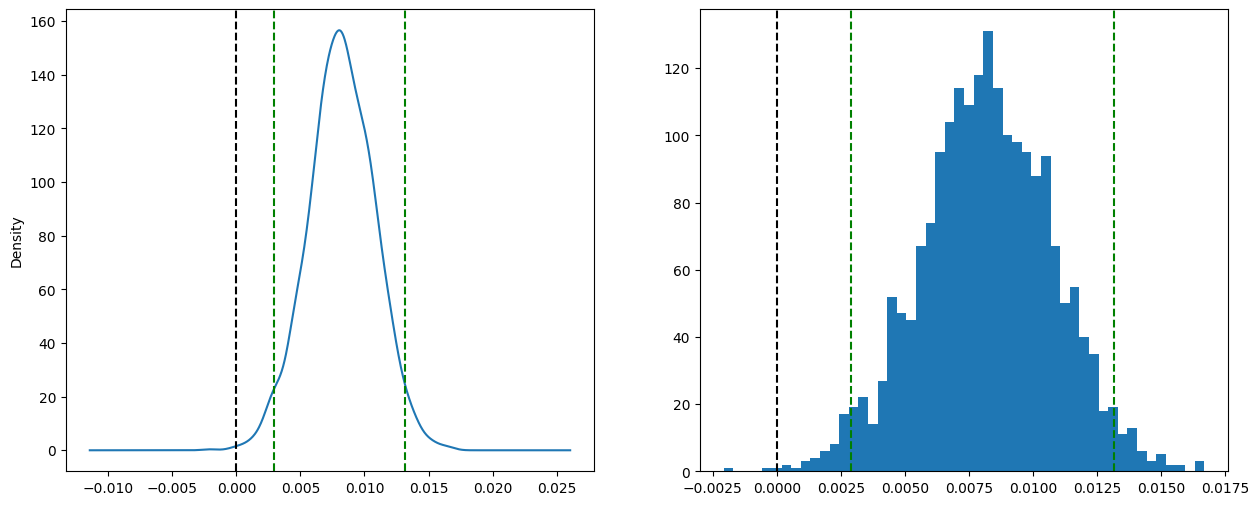

In [26]:
sr = pd.Series(boot_corrected)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
sr.plot(kind='density', ax=ax1)
ax1.axvline(x=0, color='black', linestyle='--')
ax1.axvline(x=sr.quantile(left_ci), color='green', linestyle='--')
ax1.axvline(x=sr.quantile(right_ci), color='green', linestyle='--')

ax2.hist(sr, bins = 50)
ax2.axvline(x=0, color='black', linestyle='--')
ax2.axvline(x=sr.quantile(left_ci), color='green', linestyle='--')
ax2.axvline(x=sr.quantile(right_ci), color='green', linestyle='--')

Вспомним, что в данном случае мы смотрим на разности средних. Тогда, если 0 попадает внутрь доверительного интервала, считаем разницу средних нестатзначимой. Здесь видим, что 0 за пределами 95% доверительного интервала, значит, отвергаем нулевую гипотезу.

! Нельзя после бутстрапа использовать критерии, требующие независимости данных, так как в подвыборки попадают значения из одного набора.

## Ratio-метрики

In [27]:
conversion_data = pd.read_csv('../data/KAG_conversion_data.csv')
conversion_data

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.430000,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710001,8,2


Ratio-метрика — отношение двух случайных величин, часто зависимых.<br>
Пример: CTR (Click Through Rate)

In [28]:
conversion_data['CTR'] = conversion_data['Clicks'] / conversion_data['Impressions']
conversion_data[['Clicks', 'Impressions', 'CTR']]

,Clicks,Impressions,CTR
0,1,7350,0.000136
1,2,17861,0.000112
2,0,693,0.000000
3,1,4259,0.000235
4,1,4133,0.000242
...,...,...,...
1138,252,1129773,0.000223
1139,120,637549,0.000188
1140,28,151531,0.000185
1141,135,790253,0.000171


Наивный способ подсчёта CTR: $$\frac{\frac{Clicks_1}{Impressions_1} + ... + \frac{Clicks_n}{Impressions_n}}{n}$$

In [29]:
n = conversion_data.shape[0]
ctr_n = conversion_data['CTR'].sum() / n
print('Naive CTR:\t', ctr_n)

Naive CTR:	 0.00016419671305996467


Наивный CTR не учитывает вес ($\frac{1}{10} = \frac{1000}{10000}$), результат будет смещён.<br>
Глобальный CTR: $$\frac{Clicks_1 + ... + Clicks_n}{Impressions_1 + ... + Impressions_n}$$

In [30]:
ctr_g = conversion_data['Clicks'].sum() / conversion_data['Impressions'].sum()
bias = ctr_g - ctr_n
print('Global CTR:\t', ctr_g)
print('Bias:\t\t', bias)

Global CTR:	 0.00017881336592357833
Bias:		 1.4616652863613658e-05


In [31]:
conversion_data.age.unique()

array(['30-34', '35-39', '40-44', '45-49'], dtype=object)

Сравним CTR двух возрасных групп. Мы не можем использовать критерии, требующие независимости данных. Можем использовать, например, непараметрический критерий Манна-Уитни.

In [32]:
from scipy.stats import mannwhitneyu

group_A = conversion_data[conversion_data['age'].isin(['30-34', '35-39'])]
group_B = conversion_data[conversion_data['age'].isin(['40-44', '45-49'])]
mannwhitneyu(group_A['CTR'], group_B['CTR'], alternative='two-sided').pvalue

4.634899794567663e-35

Или бутстрап.

In [33]:
iterations = 10000
ctr_A = group_A.Clicks.sum() / group_A.Impressions.sum()
ctr_B = group_B.Clicks.sum() / group_B.Impressions.sum()
ctr_delta = abs(ctr_A - ctr_B)
result = []

for i in tqdm(range(iterations)):
    sample_A = group_A.sample(frac=1, replace=True)
    sample_B = group_B.sample(frac=1, replace=True)
    ctr_boot_A = sample_A.Clicks.sum() / sample_A.Impressions.sum()
    ctr_boot_B = sample_B.Clicks.sum() / sample_B.Impressions.sum()
    result.append(ctr_boot_B - ctr_boot_A)

100%|██████████| 10000/10000 [01:03<00:00, 158.65it/s]


In [34]:
alpha = 0.05
result_series = pd.Series(result)

B_global_ctr = group_B['Clicks'].sum() / group_B['Impressions'].sum()
A_global_ctr = group_A['Clicks'].sum() / group_A['Impressions'].sum()
print('Global CTR:\t\t', (B_global_ctr - A_global_ctr))
print('Bootstrap CTR:\t\t', result_series.mean())
print('Bias:\t\t\t', result_series.mean() - (B_global_ctr - A_global_ctr))

print()
left_ci = np.quantile(result_series, alpha / 2)
right_ci = np.quantile(result_series, 1 - alpha / 2)
print('Доверительный инетрвал:\t', left_ci, right_ci)
print('Стандартная ошибка:\t', result_series.std())

Global CTR:		 5.834206219780682e-05
Bootstrap CTR:		 5.838578399305225e-05
Bias:			 4.372179524543253e-08

Доверительный инетрвал:	 4.8906057118877366e-05 6.78215897757269e-05
Стандартная ошибка:	 4.806368904690615e-06


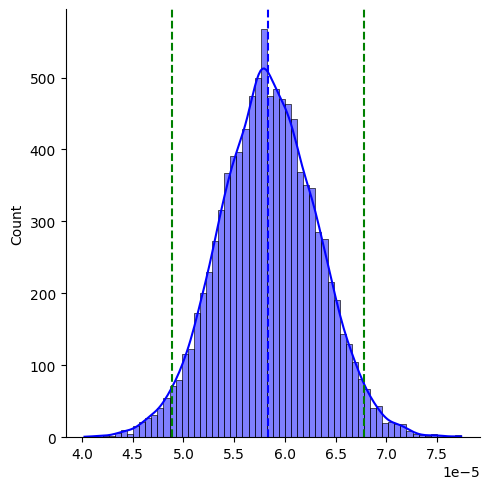

In [35]:
sns.displot(result_series, kde=True, color='blue')
plt.axvline(result_series.mean(), color='blue', linestyle='--')
plt.axvline(x=left_ci, color='green', linestyle='--')
plt.axvline(x=right_ci, color='green', linestyle='--')
plt.show()

Ноль снова не попал в доверительный интервал, значит, есть статистически значимая разница в CTR.

## Delta-метод

Delta-метод (он же метод построения доверительного интервала со стабилизацией дисперсии) позволяет использовать критерии, требующие вычисление дисперсии, для сложных случаев. Например, для ratio-метрик.

Метод утверждает, что функции от состоятельной и асимптотически нормальной оценки параметра будет иметь асимптотически нормальное распределение с известной дисперсии. Вывод этого результата использует ряд Тейлора и мы не будем здесь его приводить, воспользуемся уже известной оценкой дисперсии.

Проблемой было вычисление дисперсии отношения зависимых величин. Формула оценки дисперсии отношения:
$$var(\frac{X}{Y})\approx \frac{1}{\mu^2_y}var(X) - 2\frac{\mu_x}{\mu^3_y}cov(X,Y)+\frac{\mu^2_x}{\mu^3_y}var(Y)$$

In [36]:
def get_ratio_var(m_x, m_y, v_x, v_y, cov):
    return v_x / (m_y ** 2) - 2 * m_x * cov / (m_y ** 3) + (m_x ** 2) * v_y / (m_y ** 4)

Подставим эту оценку в вычисление дисперсии глобальной ratio-метрики:
$$var(R)=var(\frac{X_1+...+X_N}{Y_1+...+Y_N}) = var(\frac{\overline{X}}{\overline{Y}}) \approx \frac{1}{\mu^2_y}var(\overline{X}) - 2\frac{\mu_x}{\mu^3_y}cov(\overline{X},\overline{Y})+\frac{\mu^2_x}{\mu^3_y}var(\overline{Y}) = $$
$$=\frac{1}{N}(\frac{1}{\mu^2_y}var(X) - 2\frac{\mu_x}{\mu^3_y}cov(X,Y)+\frac{\mu^2_x}{\mu^3_y}var(Y))$$

In [37]:
def get_metric_var(group: pd.DataFrame):
    n = group.shape[0]

    mean_clicks  = group.Clicks.mean()
    mean_impressions = group.Impressions.mean()
    cov = ((group.Clicks - mean_clicks) * (group.Impressions - mean_impressions)).mean()

    var_clicks = group.Clicks.var()
    var_impressions = group.Impressions.var()
    var = get_ratio_var(mean_clicks, mean_impressions, var_clicks, var_impressions, cov)
    return var / n

Полученные дисперсии используются для расчёта t-статистики:
$$t = \frac{\frac{X_t}{Y_t} - \frac{X_c}{Y_c}}{\sqrt{var(R_c) + var(R_t)}}$$

In [38]:
def get_t(A, B):
    ratio_A = A.Clicks.sum() / A.Impressions.sum()
    ratio_B = B.Clicks.sum() / B.Impressions.sum()
    var_A = get_metric_var(A)
    var_B = get_metric_var(B)
    return (ratio_B - ratio_A) / np.sqrt(var_A + var_B)

get_t(group_A, group_B)

11.92504406106552

Теперь можем вычислять p-values.

In [39]:
iterations = 3000
result = []

for i in tqdm(range(iterations)):
    sample_A = group_A.sample(frac=1, replace=True)
    sample_B = group_B.sample(frac=1, replace=True)
    t = get_t(sample_A, sample_B)
    pvalue = 2 * np.minimum(norm(0, 1).cdf(t), 1 - norm(0, 1).cdf(t))
    result.append(pvalue)

100%|██████████| 3000/3000 [00:55<00:00, 53.76it/s]


In [40]:
result_series = pd.Series(result)
result_series[result_series > 0]

2375    9.414691e-14
dtype: float64

Видим, что результат совпадает с результатом простого бутстрапирования: очень маленькие p-value и опровержение $H_0$.